## Transformations recommended to apply to each input image:
- The first pytorch recommended transformation is transforms.ToTensor() 
  - transforms.ToTensor() 
    - converting PIL Image to PyTorch Tensor image in range 0,1 (for each channel?)
     
     * Our input is not PIL therefore we do it manually
        - For the batch of all samples for each channel we transform the each images in that channel to 0,1 range
          - Currently minimum is 0 but max is variable for different images of a batch, I have decided to not change that

  - transforms.Normalize(mean, std)
    - The mean and std of the whole dataset is caluculated and this transformation is applied to each single image
    - I will run a function to apply this transformation to all images all in once and not in dataloader.
    
  

In [111]:
%load_ext autoreload
%autoreload 2
import numpy as np
import requests
from PIL import Image
import io
import torch
from singlecell.visualize import image_intensity_adjustments

import albumentations
import albumentations.pytorch

"""
torchvision_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
"""

# Same transform with torchvision_transform
# albumentations_transform = albumentations.Compose([
#     albumentations.HorizontalFlip()
# ])

# albumentations_transform_oneof = albumentations.Compose([
#     albumentations.OneOf([albumentations.HorizontalFlip(p=1),
#                           albumentations.RandomRotate90(p=1),
#                           albumentations.VerticalFlip(p=1)])])


transform_albm = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.pytorch.transforms.ToTensorV2()
])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## Load example single cells which are save as numpy array to the disk
root_im_arr="/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/gan_be/"
# root_im_arr="/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/gan_l1k_ssCP_data_22/"
all_ss_ims=np.load(root_im_arr+'/ims_array.npy')

all_ss_ims_2 = all_ss_ims.transpose((0,3, 1, 2)) # convert from numpy image: H x W x C to torch image: C X H X W
all_ss_ims_tensor=torch.from_numpy(all_ss_ims_2).float()

all_ss_ims_tensor_normalized,mean_s, std_s = pytorch_batch_transformation(all_ss_ims_tensor)

In [103]:
all_ss_ims_tensor.shape,all_ss_ims_tensor[0,0,:,:].shape,all_ss_ims_tensor[0,0,:,:].numpy().shape

(torch.Size([8725, 5, 128, 128]), torch.Size([128, 128]), (128, 128))

In [112]:
image_intensity_adjustments.CP_to_RGB_single(all_ss_ims_tensor[0,:,:,:].numpy()).shape,std_s.shape

((3, 128, 128), torch.Size([5, 1, 1]))

In [113]:
aug_im.shape

(128, 128, 5)

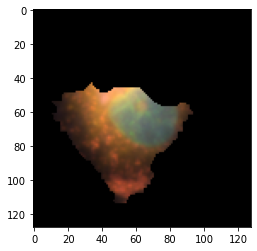

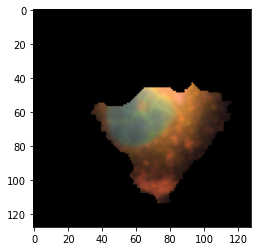

In [112]:
plt.figure()
# plt.imshow(all_ss_ims_tensor[0,0,:,:].numpy())
plt.imshow(np.moveaxis(image_intensity_adjustments.CP_to_RGB_single(all_ss_ims_tensor[0,:,:,:].numpy()), 0, 2))
# plt.figure()
# plt.imshow(np.moveaxis(image_intensity_adjustments.CP_to_RGB_single(all_ss_ims_tensor_normalized[0,:,:,:].numpy()), 0, 2))
# revesed_im=all_ss_ims_tensor_normalized[0,:,:,:]*std_s+mean_s
# plt.figure()
# plt.imshow(np.moveaxis(image_intensity_adjustments.CP_to_RGB_single(revesed_im.numpy()), 0, 2))
aug_im= transform_albm(image=np.moveaxis(all_ss_ims_tensor[0,:,:,:].numpy(), 0, 2))['image']
plt.figure()
plt.imshow(image_intensity_adjustments.CP_to_RGB_single(aug_im))

In [114]:
np.moveaxis(revesed_im.numpy(), 0, 2).shape

(128, 128, 5)

In [90]:
all_ss_ims_tensor_normalized,mean_s, std_s = pytorch_batch_transformation(all_ss_ims_tensor)

In [43]:
print(all_ss_ims.shape)

sample_i=3

for i in range(5):
    print(np.min(all_ss_ims[sample_i,:,:,i]),np.max(all_ss_ims[sample_i,:,:,i]),np.mean(all_ss_ims[sample_i,:,:,i]))
    print(np.min(all_ss_ims[:,:,:,i]),np.max(all_ss_ims[:,:,:,i]),np.mean(all_ss_ims[:,:,:,i]))

(8725, 128, 128, 5)
0.0 0.48627450980392156 0.08543174594056374
0.0 1.0 0.04246918930033429
0.0 0.4666666666666667 0.0358154296875
0.0 1.0 0.020204577307886776
0.0 0.43529411764705883 0.06786271637561275
0.0 1.0 0.03623161401546717
0.0 0.7450980392156863 0.04840734145220589
0.0 1.0 0.02441876682533466
0.0 0.4666666666666667 0.0639871036305147
0.0 1.0 0.038281469493909745


In [96]:
sample_i=0
x2=(all_ss_ims_tensor_normalized[sample_i,:,:,:]*std_s)+mean_s

In [98]:
all_ss_ims_tensor[sample_i,:,:,:].min(),all_ss_ims_tensor[sample_i,:,:,:].max()

(tensor(0.), tensor(0.7961))

In [97]:
x2.max()

tensor(0.7961)

In [93]:
all_ss_ims_tensor_normalized[sample_i,:,:,:].shape

torch.Size([5, 128, 128])

In [89]:
def pytorch_batch_transformation(all_ss_ims_tensor):
    """ Removes the mean and make std unit for all samples in each channel
    Input:
        all_ss_ims_tensor -> shape (n_samples,n_channels,hight,width)

    Output:
        normalized images
    """
    n_channels=all_ss_ims_tensor.shape[1]
    mean_1, std_1 = all_ss_ims_tensor.mean([0,2,3]), all_ss_ims_tensor.std([0,2,3])

    all_ss_ims_tensor_rm_mean=all_ss_ims_tensor-mean_1.reshape((1,n_channels,1,1));
    all_ss_ims_tensor_normalized=all_ss_ims_tensor_rm_mean/std_1.reshape((1,n_channels,1,1));

    return all_ss_ims_tensor_normalized, mean_1.reshape((n_channels,1,1)), std_1.reshape((n_channels,1,1))


In [53]:
print(all_ss_ims_tensor.shape)

torch.Size([8725, 5, 128, 128])


In [71]:
mean_1, std_1 = all_ss_ims_tensor.mean([0,2,3]), all_ss_ims_tensor.std([0,2,3])
 
# print mean and std
print("mean and std before normalize:")
print("Mean of the image:", mean_1)
print("Std of the image:", std_1)

mean and std before normalize:
Mean of the image: tensor([0.0425, 0.0202, 0.0362, 0.0244, 0.0383])
Std of the image: tensor([0.1190, 0.0875, 0.1053, 0.0813, 0.1074])


In [55]:
all_ss_ims_tensor

torch.Size([8725, 5, 128, 128])

In [78]:
all_ss_ims_tensor_rm_mean=all_ss_ims_tensor-mean_1.reshape((1,5,1,1))
all_ss_ims_tensor_normalized=all_ss_ims_tensor_rm_mean/std_1.reshape((1,5,1,1))
mean_2, std_2 = all_ss_ims_tensor_normalized.mean([0,2,3]), all_ss_ims_tensor_normalized.std([0,2,3])
print("mean and std before normalize:")
print("Mean of the image:", mean_2)
print("Std of the image:", std_2)

mean and std before normalize:
Mean of the image: tensor([-4.8968e-08,  6.1319e-08,  8.9779e-08,  1.2215e-08,  8.7156e-08])
Std of the image: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [72]:
all_ss_ims_tensor[sample_i,:,:,i].shape

torch.Size([5, 128])

In [74]:
sample_i=5

for i in range(5):
#     print(all_ss_ims_tensor[sample_i,i,:,:].min(),all_ss_ims_tensor[sample_i,i,:,:].max(),all_ss_ims_tensor[sample_i,i,:,:].mean())

    print(all_ss_ims_tensor_normalized[sample_i,i,:,:].min(),all_ss_ims_tensor_normalized[sample_i,i,:,:].max(),all_ss_ims_tensor_normalized[sample_i,i,:,:].mean())
    print(all_ss_ims_tensor_normalized[:,i,:,:].min(),all_ss_ims_tensor_normalized[:,i,:,:].max(),all_ss_ims_tensor_normalized[:,i,:,:].mean())


tensor(-0.3570) tensor(3.3021) tensor(0.0700)
tensor(-0.3570) tensor(8.0490) tensor(-4.1098e-08)
tensor(-0.2310) tensor(6.1344) tensor(0.0602)
tensor(-0.2310) tensor(11.1998) tensor(9.2034e-08)
tensor(-0.3439) tensor(3.7137) tensor(0.1482)
tensor(-0.3439) tensor(9.1488) tensor(-7.9573e-08)
tensor(-0.3003) tensor(1.9179) tensor(-0.0124)
tensor(-0.3003) tensor(11.9964) tensor(1.0056e-07)
tensor(-0.3563) tensor(2.3815) tensor(0.0085)
tensor(-0.3563) tensor(8.9522) tensor(1.0056e-08)


Text(0.5, 1.0, 'distribution of pixels')

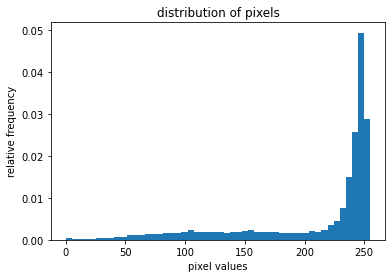

In [5]:
# python code to load and visualize
# an image
 
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
 
# load the image
img_pil = Image.open('cat.jpg')
# img_pil
 
# convert PIL image to numpy array
img_np = np.array(img_pil)
 
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

Text(0.5, 1.0, 'distribution of pixels')

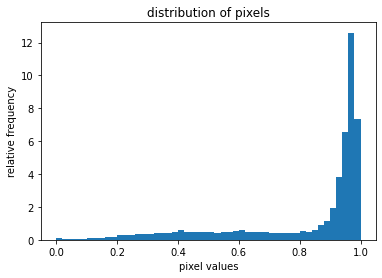

In [6]:
# Python code for converting PIL Image to
# PyTorch Tensor image and plot pixel values
 
# import necessary libraries
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
 
# define custom transform function
transform = transforms.Compose([
    transforms.ToTensor()
])
 
# transform the pIL image to tensor
# image
img_tr = transform(img_pil)
 
# Convert tensor image to numpy array
img_np = np.array(img_tr)

 
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [7]:
# Python code to calculate mean and std
# of image
 
# get tensor image
# img_tr = transform(img)
 
# calculate mean and std
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])
 
# print mean and std
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.8238, 0.8168, 0.8180])
Std of the image: tensor([0.2132, 0.2377, 0.2508])


Text(0.5, 1.0, 'distribution of pixels')

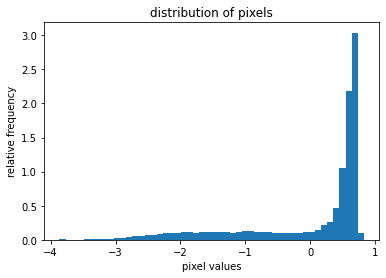

In [32]:
from torchvision import transforms
 
# define custom transform
# here we are using our calculated
# mean & std
transform_norm = transforms.Compose([
    transforms.Normalize(mean, std)
])
 
# get normalized image
img_normalized = transform_norm(img_tr)
 
# convert normalized image to numpy
# array
img_np = np.array(img_normalized)
 
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [ ]:
plt.figure()
plt.imshow(np.moveaxis(img_np,0,2))

In [42]:
np.moveaxis(img_np,0,2).shape

(372, 560, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


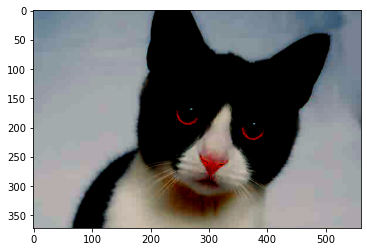

In [81]:
import albumentations

"""
torchvision_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
"""

# Same transform with torchvision_transform
# albumentations_transform = albumentations.Compose([
#     albumentations.HorizontalFlip()
# ])

albumentations_transform_oneof = albumentations.Compose([
    albumentations.OneOf([albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)])])


# get normalized image
transformed_image_1 = albumentations_transform_oneof(image=np.moveaxis(img_np,0,2))['image']
# img_normalized = albumentations_transform(img_tr)
 
# convert normalized image to numpy
# array
img_np2 = np.array(transformed_image_1)

plt.figure()
plt.imshow(img_np2)

array([[[0.40366107, 0.5066607 , 0.6005971 ],
        [0.40366107, 0.5066607 , 0.6005971 ],
        [0.40366107, 0.5066607 , 0.6005971 ],
        ...,
        [0.42205814, 0.49016047, 0.5536879 ],
        [0.42205814, 0.49016047, 0.5536879 ],
        [0.42205814, 0.49016047, 0.5536879 ]],

       [[0.40366107, 0.5066607 , 0.6005971 ],
        [0.40366107, 0.5066607 , 0.6005971 ],
        [0.40366107, 0.5066607 , 0.6005971 ],
        ...,
        [0.42205814, 0.49016047, 0.5536879 ],
        [0.42205814, 0.49016047, 0.5536879 ],
        [0.42205814, 0.49016047, 0.5536879 ]],

       [[0.40366107, 0.5066607 , 0.6005971 ],
        [0.40366107, 0.5066607 , 0.6005971 ],
        [0.40366107, 0.5066607 , 0.6005971 ],
        ...,
        [0.42205814, 0.49016047, 0.5536879 ],
        [0.42205814, 0.49016047, 0.5536879 ],
        [0.42205814, 0.49016047, 0.5536879 ]],

       ...,

       [[0.6980141 , 0.6716632 , 0.6944155 ],
        [0.6980141 , 0.6716632 , 0.6944155 ],
        [0.6980141 , 0

In [63]:
# img_np = np.array(transformed_image_1)

# plt.figure()
# plt.imshow(np.moveaxis(img_np,0,2))

In [18]:
img_tr.shape#,np.min(np.min(img_tr,axis=2),axis=1),np.max(np.max(img_tr,axis=2),axis=1)

torch.Size([3, 372, 560])

In [22]:
x=np.array(img_pil)
x.shape

(372, 560, 3)

In [28]:
x[:,:,0].max()

255

In [14]:
img_np.shape,np.min(np.min(img_np,axis=2),axis=1),np.max(np.max(img_np,axis=2),axis=1)

((3, 372, 560),
 array([0., 0., 0.], dtype=float32),
 array([1., 1., 1.], dtype=float32))

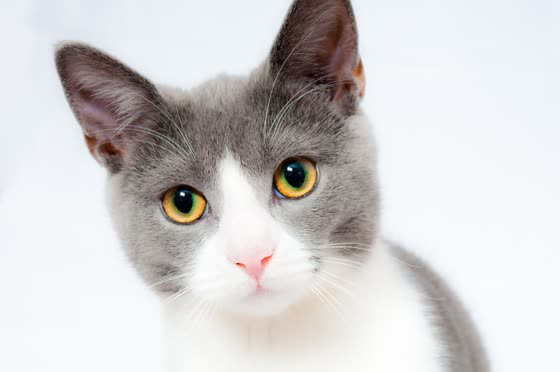

In [14]:
# resp = requests.get('https://jbencook.s3.amazonaws.com/assets/img/cat.jpg')
# img_pil = Image.open(io.BytesIO(resp.content))

In [ ]:
url = 'https://www.python.org/images/python-logo.gif'